# MCLの説明

- MCL
    - 自己位置推定手法の一つ
    - ロボットの姿勢（位置、向き）を確率分布で表現
        - 実際にアルゴリズムを組む際には、確率分布を「パーティクル」で近似
        - パーティクル
            - ロボットの分身
            - 
            - ロボットの姿勢情報と、実ロボットがその姿勢になる確率を表す重みを持つ

## 使用するライブラリのインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import math
from matplotlib.patches import Circle
import matplotlib.collections as mc 
import random

## ランドマークとその観測結果、ロボット、パーティクルを描画する関数

In [2]:
def draw(landmarks, actual_pose, particles, zs=None):
    # ----グラフの設定----
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    # --------------------
    
    # ----ランドマーク----
    x = [landmark[0] for landmark in landmarks]
    y = [landmark[1] for landmark in landmarks]
    plt.scatter(x, y, marker='*')
    # --------------------
    
    # ----ロボット----
    x, y, theta = actual_pose[0], actual_pose[1], actual_pose[2]
    cr = 0.5
    cir = Circle(xy=(x, y), radius=cr, fill=False)
    x_end = x + cr * math.cos(theta)
    y_end = y + cr * math.sin(theta)
    plt.plot([x, x_end], [y, y_end], color="black")
    ax.add_artist(cir)
    # ----------------
    
    # ----パーティクル----
    xs = [particle.p[0] for particle in particles]
    ys = [particle.p[1] for particle in particles]
    xe = [math.cos(particle.p[2])*particle.w for particle in particles]
    ye = [math.sin(particle.p[2])*particle.w for particle in particles]
#     scales = [particle.w for particle in particles]
    plt.quiver(xs, ys, xe, ye, color='green', alpha=0.4)
    # --------------------
    
    # ----観測結果----
    if(zs != None):
        lines = [[(x, y), (x+z[0]*math.cos(z[1]), y+z[0]*math.sin(z[1]))] for z in zs]
        lines_plot = mc.LineCollection(lines, color='red')
        ax.add_collection(lines_plot)
    # ----------------

## 1つ前の時間の姿勢と現在入ってきた速度入力から現在の姿勢を計算する関数

In [3]:
def cmd_vel2xyt(now_p, cmd_vel, dt):
    p = [0, 0, 0]
    if cmd_vel[1] == 0.0:
        p = [
            now_p[0] + cmd_vel[0]*math.cos(now_p[2])*dt, 
            now_p[1] + cmd_vel[0]*math.sin(now_p[2])*dt, 
            now_p[2] + cmd_vel[1]*dt
        ]
    else:
        theta_tmp = now_p[2] + cmd_vel[1]*dt
        p = [
            now_p[0] + cmd_vel[0]/cmd_vel[1]*(math.sin(theta_tmp)-math.sin(now_p[2])), 
            now_p[1] + cmd_vel[0]/cmd_vel[1]*(-math.cos(theta_tmp)+math.cos(now_p[2])), 
            now_p[2] + cmd_vel[1]*dt
        ]
    while p[2] >= math.pi:
        p[2] -= 2*math.pi

    while p[2] < -math.pi:
        p[2] += 2*math.pi
    return p

## ランドマークを観測する関数

In [4]:
def observe_landmark(pose, landmarks):
    x, y = pose[0], pose[1]
    zs = []
    for landmark in landmarks:
        diff_x = landmark[0] - x
        diff_y = landmark[1] - y
        r = math.sqrt(diff_x**2 + diff_y**2)
        phi = math.atan2(diff_y, diff_x)
        zs.append([r, phi])
    return zs

## パーティクルクラスの定義

In [17]:
class Particle():
    def __init__(self, landmarks, p, motion_noise_sigma, cmd_vel, dt, weight, observe_noise_sigma):
        self.landmarks = landmarks
        self.p = p
        self.motion_noise_sigma = motion_noise_sigma
        self.cmd_vel = cmd_vel
        self.dt = dt
        
        s = motion_noise_sigma
        motion_cov = np.diag([s[0]**2, s[1]**2, s[2]**2, s[3]**2])
#         print(motion_cov)
        self.motion_update_mult_norm = multivariate_normal([0, 0, 0, 0], motion_cov)
        
        self.w = weight
        self.observe_noise_sigma = observe_noise_sigma
        
    def motion_update(self):
#         print(self.motion_update_mult_norm.rvs())
        noise_cmd_vel = self.add_motion_noise()
        self.p = cmd_vel2xyt(self.p, noise_cmd_vel, self.dt)
    
    def add_motion_noise(self):
        noises = self.motion_update_mult_norm.rvs()
        noise_cmd_vel = [
            self.cmd_vel[0] + noises[0]*math.sqrt(abs(self.cmd_vel[0])/self.dt) + noises[1]*math.sqrt(abs(self.cmd_vel[1])/self.dt), 
            self.cmd_vel[1] + noises[2]*math.sqrt(abs(self.cmd_vel[0])/self.dt) + noises[3]*math.sqrt(abs(self.cmd_vel[1])/self.dt)
        ]
        return noise_cmd_vel
    
    def observed_update(self, zs):
        p_zs = observe_landmark(self.p, landmarks)
        for z, p_z in zip(zs, p_zs):
            print(z)
            print(p_z)
            observe_cov = np.diag([(p_z[0]*self.observe_noise_sigma[0])**2, self.observe_noise_sigma[1]**2])
            self.w *= multivariate_normal(cov=observe_cov, mean=p_z).pdf(z)
#             observe_update_mult_norm = multivariate_normal(cov=observe_cov, mean=p_z)
#             likelihood = observe_update_mult_norm.pdf(z)
#             print(likelihood)
#             self.w *= likelihood
        print(f'weight: {self.w}')
            

## リサンプリング

In [18]:
def resampling(particles):
    w = []
#     for particle in particles:
#         w.append(particle.w)
    w = [particle.w for particle in particles]
#     print(w)
    w_cumsum = np.cumsum(w)
#     print(w_cumsum)
    if w_cumsum[-1] <1e-100:
        w_cumsum = [1 / len(particles) for i in ra]
    w_sum = w_cumsum[-1]
    
    space = 1 / w_sum
    p_weight = random.uniform(0, space)
    new_p = []
    new_index = 0
    while len(new_p) < len(particles):
#         print(len(new_p), new_index)
        if(new_index > len(particles)):
            new_index = len(particles)
        if p_weight < w_cumsum[new_index]:
            new_p.append(particles[new_index])
            p_weight += space
        
        else:
#             p_weight += space
            new_index += 1
    return new_p


In [19]:
p0 = [0.0, 0.0, 0.0] # ロボットの初期位置
motion_noise_sigma = [0.19, 0.001, 0.13, 0.2]
cmd_vel = [0.1, 0.1]
dt = 1.0
n = 10 # パーティクルの数
landmarks = np.array([[5, 5], [-4, 7], [6, -8], [-5, -7]])
weight = 1 / n
observe_noise_sigma = [0.13, 0.01]
p = p0

[6.997263690597627, 0.7949820988997268]
[6.984528919392731, 0.7973110967395491]
[8.107941620196272, 2.100939079722693]
[8.120319965846575, 2.102979270440067]
[9.944441865948717, -0.9356280328777904]
[9.93042337515797, -0.9371566512595652]
[8.664771637038097, -2.2000864537886655]
[8.67503229054916, -2.202156150987242]
weight: 4238.858676503587
[6.997263690597627, 0.7949820988997268]
[7.00692947610671, 0.7944964006474803]
[8.107941620196272, 2.100939079722693]
[8.10719330683946, 2.0996786182717067]
[9.944441865948717, -0.9356280328777904]
[9.946268835175045, -0.9346142482813408]
[8.664771637038097, -2.2000864537886655]
[8.655708437431471, -2.1995344627319726]
weight: 4521.175360702024
[6.997263690597627, 0.7949820988997268]
[7.035340452065183, 0.790483631807364]
[8.107941620196272, 2.100939079722693]
[8.087470023159309, 2.0953792739740282]
[9.944441865948717, -0.9356280328777904]
[9.969729550748497, -0.9313593407245048]
[8.664771637038097, -2.2000864537886655]
[8.631872638681298, -2.1958

NameError: name 'ra' is not defined

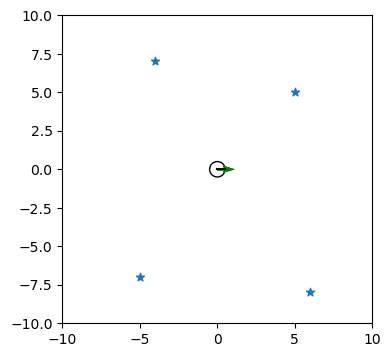

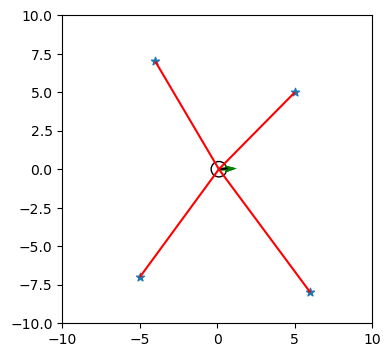

In [20]:
particles = [Particle(landmarks, p0, motion_noise_sigma, cmd_vel, dt, weight, observe_noise_sigma) for i in range(n)]
draw(landmarks, p, particles) # 時刻0における状態の描画
for i in range(20):
    p = cmd_vel2xyt(p, cmd_vel, dt)
    for particle in particles:
        particle.motion_update()
    
    zs = observe_landmark(p, landmarks)
    for particle in particles:
        particle.observed_update(zs)
        
    new_ps = resampling(particles)
    particles = [new_p for new_p in new_ps]
    for particle in particles:
        particle.w = 1 / len(particles)
#     resampling(particles)
    draw(landmarks, p, particles, zs)

In [25]:
z = (6.997263690597627, 0.7949820988997268)
p_z = (7.035340452065183, 0.790483631807364)
m = multivariate_normal(cov=np.diag([(p_z[0]*observe_noise_sigma[0])**2, observe_noise_sigma[1]**2]), mean=p_z)
m.pdf(z)

15.71349983617763